<pre>
In this notebook, You will do Spoken Digit Recognition. 

Input - speech signal, output - digit number



It contains  

1. Reading the dataset. and Preprocess the data set. 
2. Training the LSTM with RAW data
3. Converting to spectrogram and Training the LSTM network
4. Creating the augmented data and doing step 2 and 3 again.  


</pre>

#### Import Packages

In [ ]:
import numpy as np
import pandas as pd
import librosa
import os
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, LSTM, Flatten, Masking, GlobalAveragePooling1D
from tensorflow.keras.models import Model
import tensorflow as tf
from keras import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
# import tensorflow_addons as tfa
from keras.callbacks import TensorBoard, ReduceLROnPlateau

In [ ]:
!unzip "/content/recordings.zip"                        # unzip file

In [ ]:
# store the wav file names
all_files = os.listdir('/content/recordings')
all_files[:5], len(all_files)

(['4_lucas_18.wav',
  '8_jackson_43.wav',
  '1_nicolas_13.wav',
  '6_jackson_1.wav',
  '2_jackson_40.wav'],
 3000)

In [ ]:
# Create a dataframe(name=df_audio) with two columns(path, label).   
# You can get the label from the first letter of name.  
# Eg: 0_jackson_0 --> 0  
# 0_jackson_43 --> 0

In [ ]:
df_audio = pd.DataFrame()

# add all files path
df_audio['path']   = all_files
# create label column
df_audio['label']  = df_audio['path'].str[0].astype(int)
# add files full path
df_audio['path']   = "/content/recordings/" + df_audio['path'] 

In [ ]:
df_audio.label.value_counts()                       # label counts

4    300
8    300
1    300
6    300
2    300
5    300
9    300
0    300
3    300
7    300
Name: label, dtype: int64

In [ ]:
# info
df_audio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    3000 non-null   object
 1   label   3000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 47.0+ KB


<pre><font size=4>Train and Validation split</font></pre>

In [ ]:
# split the data into train and validation and save in X_train, X_test, y_train, y_test
# use stratify sampling

x = df_audio['path']
y = df_audio['label']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, stratify = y, random_state = 45, shuffle=True)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2100,) (2100,)
(900,) (900,)


<pre><font size=4>Preprocessing</font>

All files are in the "WAV" format. We will read those raw data files using the librosa</pre>

In [ ]:
sample_rate = 22050

def load_wav(audio_file, get_duration=True):


    '''
    Input :
        name    : audio_file
        type    : str
        content : audio file path 

        name    : get_duration 
        type    : bool
        content : audio file duration

    Output :
        name    : samples
        type    : np.array
        content : convert audio file into np.array using librosa

        name    : duration
        type    : int
        content : sampling rate of audio file


    Process :
        This function take audio file path and using librosa package
        gives numpy array and sampling rate of audio file.  
    
    '''


    # load audio file
    samples, sample_rate = librosa.load(audio_file, sr=22050)
    
    # when get duration is True
    # return array and audio duration
    if get_duration:
        duration = librosa.get_duration(samples, sample_rate)
        return [samples, duration]

    # only return array
    else:
        return samples

In [ ]:
# use load_wav function that was written above to get every wave. 
# save it in X_train_processed and X_test_processed
# X_train_processed/X_test_processed should be dataframes with two columns(raw_data, duration) with same index of X_train/y_train

from tqdm.notebook import tqdm

# instantiate
tqdm.pandas()

# apply load wav functions train data
X_train_processed = pd.DataFrame(columns = ['raw_data', 'duration'])
X_train_processed['raw_data'] = X_train.progress_apply(lambda x: load_wav(x)[0])
X_train_processed['duration'] = X_train.progress_apply(lambda x: load_wav(x)[1])

# apply load wav functions train data
X_test_processed = pd.DataFrame(columns = ['raw_data', 'duration'])
X_test_processed['raw_data'] = X_test.progress_apply(lambda x: load_wav(x)[0])
X_test_processed['duration'] = X_test.progress_apply(lambda x: load_wav(x)[1])

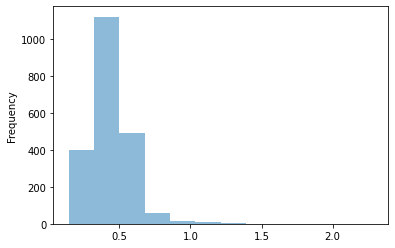

In [ ]:
# plot the histogram of the duration for train
hist1 = X_train_processed['duration'].plot.hist(bins=12, alpha=0.5)

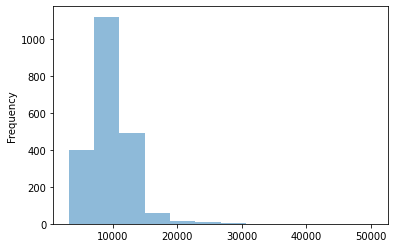

In [ ]:
X_train_processed['raw_data'].str.len().plot.hist(bins=12, alpha=0.5)             # audio array len histogram
plt.show()

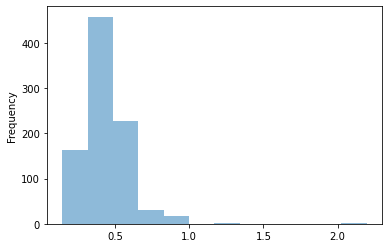

In [ ]:
# plot the histogram of the duration for train
hist2 = X_test_processed['duration'].plot.hist(bins=12, alpha=0.5)

In [ ]:
# print 0 to 100 percentile values with step size of 10 for train data duration. 
for i in range(0, 110, 10):
  a = np.percentile(X_train_processed['duration'], i)
  print(f'{i} th Percentile is  - {a}')

0 th Percentile is  - 0.1435374149659864
10 th Percentile is  - 0.2778639455782313
20 th Percentile is  - 0.32597732426303855
30 th Percentile is  - 0.36027210884353744
40 th Percentile is  - 0.39188208616780046
50 th Percentile is  - 0.42058956916099777
60 th Percentile is  - 0.4519365079365079
70 th Percentile is  - 0.48933786848072564
80 th Percentile is  - 0.5321814058956916
90 th Percentile is  - 0.6003582766439911
100 th Percentile is  - 2.282766439909297


In [ ]:
# print 90 to 100 percentile values with step size of 1. 
for i in range(0, 11):
  a = np.percentile(X_train_processed['duration'], 90+i)
  print(f'{i+90} th Percentile is  - {a}')

In [ ]:
print("Raw data len percentile :")

# print 0 to 100 percentile values with step size of 10 for train data duration. 
for i in range(0, 110, 10):
  a = np.percentile(X_train_processed['raw_data'].str.len(), i)
  print(f'{i} th Percentile is  - {round(a, 2)}')

print("*"*20)

# print 90 to 100 percentile values with step size of 1. 
for i in range(0, 11):
  a = np.percentile(X_train_processed['raw_data'].str.len(), 90+i)
  print(f'{i+90} th Percentile is  - {round(a, 2)}')

<pre>Based on our analysis 99 percentile values are less than 0.9sec so we will limit maximum length of X_train_processed and X_test_processed to 0.9 sec. It is similar to pad_sequence for a text dataset. 

While loading the audio files, we are using sampling rate of 22050 so one sec will give array of length 22050. so, our maximum length is 0.8*22050 = 17640

Pad with Zero if length of sequence is less than 19330 else Truncate the number. 

Also create a masking vector for train and test. 

masking vector value = 1 if it is real value, 0 if it is pad value. Masking vector data type must be bool.
</pre>

In [ ]:
max_length  = 19330

## as discussed above, Pad with Zero if length of sequence is less than 17640 else Truncate the number. 
## save in the X_train_pad_seq, X_test_pad_seq
## also Create masking vector X_train_mask, X_test_mask
## all the X_train_pad_seq, X_test_pad_seq, X_train_mask, X_test_mask will be numpy arrays mask vector dtype must be bool.

def zero_pad(x):

  '''
  
  Input :
    name    : x
    type    : pandas series
    content : audio array

  Output :
    name     : array
    type     : np.array
    content  : truncate and padded array

  Process :
    This function takes input as audio array and check max len
    if array greate than max len then tranucate or less than max len
    add zero padding.

  '''

  max_len = 19330
  array = [ ]
  for i in tqdm(x):

    # when len less than max value
    # add zero padding end of the array
    if len(i) < max_len: 
      i = [*i, *[0] * (max_length - len(i))]
      array.append(i)

    # when len greater than max value
    # cut to the max len
    else:
      array.append(i[:max_len])

  return np.asarray(array)


##########################################################################################

def mask_vector(x):

  ''' masking vector value = 1 if it is real value, 0 if it is pad value. Masking vector data type must be bool ''' 

  array = [ ]
  for line in tqdm(x):
    # based on  value create boolean based array
    array.append(np.where(line == 0 , False, True))
  return np.asarray(array)

In [ ]:
# use the zero pading function in the train and test
X_train_pad_seq = zero_pad(X_train_processed['raw_data'])
X_test_pad_seq = zero_pad(X_test_processed['raw_data'])

#use the mask vector fucation in the train and test
X_train_mask = mask_vector(X_train_pad_seq)
X_test_mask = mask_vector(X_test_pad_seq)

print("train and test padding shape - ", X_train_pad_seq.shape, X_test_pad_seq.shape)
print("train and test mask shape - ",    X_train_mask.shape, X_test_mask.shape)

### 1. Giving Raw data directly. 

<pre>
Now we have

Train data: X_train_pad_seq, X_train_mask and y_train  
Test data: X_test_pad_seq, X_test_mask and y_test   

We will create a LSTM model which takes this input. 

Task:

1. Create an LSTM network which takes "X_train_pad_seq" as input, "X_train_mask" as mask input. 
2. Get the final output of the LSTM and give it to Dense layer of any size and then give it to Dense layer of size 10(because we have 10 outputs) and then compile with the sparse categorical cross entropy( because we are not converting it to one hot vectors). 
</pre>

In [ ]:
## as discussed above, please write the LSTM

#clear the section
tf.keras.backend.clear_session()

#input tensor and mask
input_layer = Input(shape = (max_length, 1), name = 'input_layer', dtype = np.float32)
masking_layer = Input(shape = (max_length), dtype = 'bool', name = 'mask_layer')
mask = Masking()

#lstm layer and dense layer
lstm_layer = LSTM(250)(input_layer, mask = masking_layer)
dense_1 = Dense(units = 256, activation = 'relu')(lstm_layer)
dense_2 = Dense(units=10, activation= 'softmax')(dense_1)

model = Model(inputs = [input_layer, masking_layer],outputs = dense_2)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 19330, 1)]   0           []                               
                                                                                                  
 mask_layer (InputLayer)        [(None, 19330)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 250)          252000      ['input_layer[0][0]',            
                                                                  'mask_layer[0][0]']             
                                                                                                  
 dense (Dense)                  (None, 256)          64256       ['lstm[0][0]']               

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])    # compile model

In [ ]:
train_data = {'input_layer' : X_train_pad_seq,
              'mask_layer' : X_train_mask}                      # train data setup

test_data = {'input_layer' : X_test_pad_seq,
             'mask_layer' : X_test_mask}                        # test data setup

In [ ]:
history = model.fit(train_data, y_train, 
          epochs = 3, 
          validation_data = (test_data, y_test),
          )

Epoch 1/3
66/66 [==============================] - 57s 862ms/step - loss: 2.3032 - accuracy: 0.0843 - val_loss: 2.3026 - val_accuracy: 0.1011
Epoch 2/3
66/66 [==============================] - 58s 884ms/step - loss: 2.3031 - accuracy: 0.0862 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/3
66/66 [==============================] - 58s 878ms/step - loss: 2.3031 - accuracy: 0.0938 - val_loss: 2.3026 - val_accuracy: 0.1000


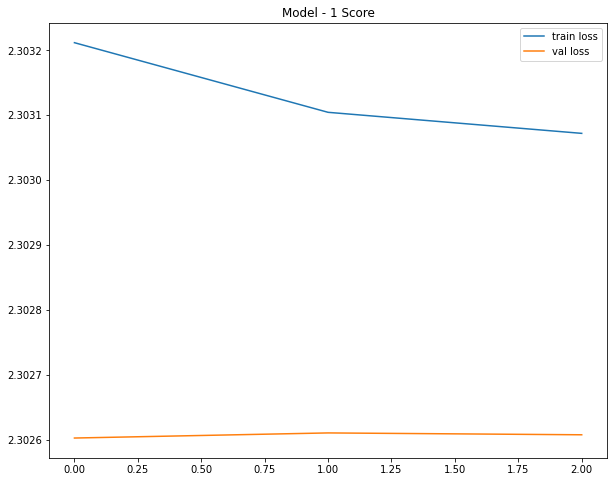

In [ ]:
######### train and val loss ##########

plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label="train loss")
plt.plot(history.history['val_loss'], label="val loss")
plt.title("Model - 1 Score")
plt.legend()
plt.show()

### 2. Converting into spectrogram and giving spectrogram data as input  
* We can use librosa to convert raw data into spectrogram. 
* A spectrogram shows the features in a two-dimensional representation with the intensity of a frequency at a point in time i.e we are converting Time domain to frequency domain. you can read more about this in https://pnsn.org/spectrograms/what-is-a-spectrogram


In [ ]:
def convert_to_spectrogram(raw_data):

    '''
    Input :
        name    : raw_data
        type    : np.array
        content : audio array


    Output :
        name    : logmel_spectrum
        type    : np.matrix
        content : spectrogram matrix

    Process :
        this function convert audio array into 
        male-spectrogram and return matrix.   
    
    '''

    spectrum = librosa.feature.melspectrogram(y=raw_data, sr=sample_rate, n_mels=64)
    logmel_spectrum = librosa.power_to_db(S=spectrum, ref=np.max)
    
    return logmel_spectrum

In [ ]:
# use convert_to_spectrogram and convert every raw sequence in X_train_pad_seq and X_test_pad-seq.
# save those all in the X_train_spectrogram and X_test_spectrogram ( These two arrays must be numpy arrays)

def create_to_spec(x):
  '''convert the pad_seq into the specogram data with calling convert_to_spectrogram '''
  array = [ ]
  for i in tqdm(x):
    spec = convert_to_spectrogram(i)
    array.append(spec)
  return np.asarray(array)

In [ ]:
X_train_spectrogram = create_to_spec(X_train_pad_seq)
X_test_spectrogram = create_to_spec(X_test_pad_seq)

X_train_spectrogram.shape, X_test_spectrogram.shape

  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

((2100, 64, 38), (900, 64, 38))

<pre>
Now we have

Train data: X_train_spectrogram and y_train  
Test data: X_test_spectrogram and y_test   

We will create a LSTM model which takes this input. 

Task:

1. Create an LSTM network which takes "X_train_spectrogram" as input and has to return output at every time step. 
2. Average the output of every time step and give this to the Dense layer of any size. 
(ex: Output from LSTM will be  (#., time_steps, features) average the output of every time step i.e, you should get (#.,time_steps) 
and then pass to dense layer )
3. give the above output to Dense layer of size 10( output layer) and train the network with sparse categorical cross entropy.  

</pre>

In [ ]:
# clear the section
tf.keras.backend.clear_session()

input_layer = Input(shape = (64,38), name = 'input_layer')

lstm_layer = LSTM(510, return_sequences = True)(input_layer)

dense_1 = Dense(units = 664,activation = 'relu')((tf.math.reduce_mean(lstm_layer, 2)))

dense_2 = Dense(units = 512,activation = 'relu')(dense_1)

dense_3 = Dense(units = 10, activation= 'softmax')(dense_2)

model = Model(inputs = input_layer,outputs = dense_3)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 64, 38)]          0         
                                                                 
 lstm (LSTM)                 (None, 64, 510)           1119960   
                                                                 
 tf.math.reduce_mean (TFOpLa  (None, 64)               0         
 mbda)                                                           
                                                                 
 dense (Dense)               (None, 664)               43160     
                                                                 
 dense_1 (Dense)             (None, 512)               340480    
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                             

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', 
                              factor = 0.5, patience = 2, 
                              min_lr = 0.0001,
                              verbose = 1)


model.compile(loss='sparse_categorical_crossentropy', optimizer= 'adam', metrics = ['accuracy'])

history2 = model.fit(X_train_spectrogram, y_train, 
          epochs = 40,
          batch_size=64, 
          validation_data = (X_test_spectrogram, y_test),
          )

Epoch 1/40
33/33 [==============================] - 3s 32ms/step - loss: 2.1253 - accuracy: 0.2271 - val_loss: 1.6522 - val_accuracy: 0.3622
Epoch 2/40
33/33 [==============================] - 1s 16ms/step - loss: 1.3492 - accuracy: 0.5243 - val_loss: 1.1585 - val_accuracy: 0.5556
Epoch 3/40
33/33 [==============================] - 1s 16ms/step - loss: 0.9821 - accuracy: 0.6476 - val_loss: 0.9779 - val_accuracy: 0.6367
Epoch 4/40
33/33 [==============================] - 1s 16ms/step - loss: 0.7624 - accuracy: 0.7329 - val_loss: 0.6663 - val_accuracy: 0.7789
Epoch 5/40
33/33 [==============================] - 1s 16ms/step - loss: 0.6013 - accuracy: 0.7876 - val_loss: 0.5946 - val_accuracy: 0.7922
Epoch 6/40
33/33 [==============================] - 1s 16ms/step - loss: 0.5573 - accuracy: 0.7981 - val_loss: 0.5871 - val_accuracy: 0.7833
Epoch 7/40
33/33 [==============================] - 1s 16ms/step - loss: 0.4773 - accuracy: 0.8348 - val_loss: 0.5172 - val_accuracy: 0.8056
Epoch 8/40
33

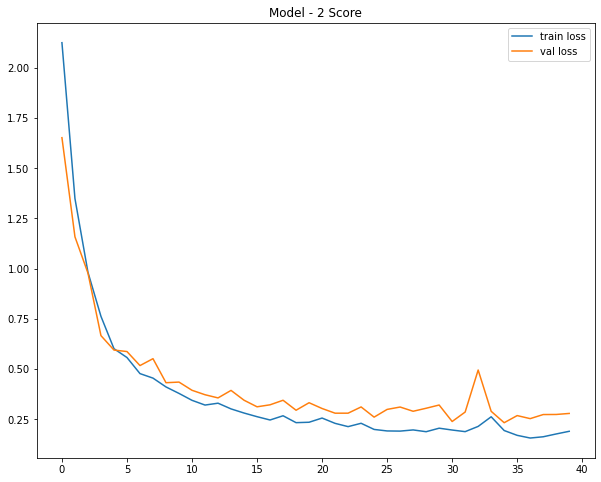

In [ ]:
############# Train and val loss ############

plt.figure(figsize=(10,8))
plt.plot(history2.history['loss'], label="train loss")
plt.plot(history2.history['val_loss'], label="val loss")
plt.title("Model - 2 Score")
plt.legend()
plt.show()

### 3. Model - 3 data augmentation  
<pre>
Till now we have done with 3000 samples only. It is very less data. We are giving the process of generating augmented data below.

There are two types of augmentation:
1. time stretching - Time stretching either increases or decreases the length of the file. For time stretching we move the file 30% faster or slower
2. pitch shifting - pitch shifting moves the frequencies higher or lower. For pitch shifting we shift up or down one half-step.
</pre>

In [ ]:
## generating augmented data. 
def generate_augmented_data(file_path):

    '''
    Input :
        name    : file_paths
        type    : str
        content : audio file path 

    Output :
        name    : augmented_data
        type    : list
        content : list of array

    Process :
        this function convert audio into array and
        create time strech and pitch shift augmentation
        and return into list 
    
    '''

    augmented_data = []
    # load file
    samples = load_wav(file_path,get_duration=False)
    # time sterch augmentation values
    for time_value in [0.7, 1, 1.3]:
        # pitch shirf values
        for pitch_value in [-1, 0, 1]:

            time_stretch_data = librosa.effects.time_stretch(samples, rate=time_value)
            final_data = librosa.effects.pitch_shift(time_stretch_data, sr=sample_rate, n_steps=pitch_value)
            augmented_data.append(final_data)
            
    return augmented_data

In [ ]:
temp_path = df_audio.iloc[0].path
aug_temp = generate_augmented_data(temp_path)

In [ ]:
len(aug_temp)

9

As discussed above, for one data point, we will get 9 augmented data points.  

Split data into train and test (80-20 split)

We have 3000 data points(2400 train points, 600 test points) 

Do augmentation only on train data, after augmentation we will get 21600 train points. 

do the above steps i.e training with raw data and spectrogram data with augmentation.

Model - 3 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y, random_state = 45)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2400,) (2400,)
(600,) (600,)


In [ ]:
def convert_arguments(X,y):

    '''

    Input :
        name    : X
        type    : pandas series
        content : column of str

        name    : y
        type    : pandas series
        content : column of int

    Output :
        name    : augmented_data
        type    : np.array
        content : list of array

        name    : augmented_labels
        type    : np.array
        content : list of array

    Process :
        this function convert audio into array and
        create time strech and pitch shift augmentation
        and return into list 
    
    '''
    
    augmented_data = []
    augmented_labels = []
    for i,j in tqdm(zip(X,y)):
        aug_data = generate_augmented_data(i)
        for k in aug_data:
            augmented_data.append(k)
            augmented_labels.append(j)
    return np.array(augmented_data), np.array(augmented_labels)

In [ ]:
aug_X_train, aug_y_train = convert_arguments(X_train,y_train)

In [ ]:
aug_X_train.shape[0], aug_y_train.shape

(21600, (21600,))

In [ ]:
############### Data for testing ############

aug_test = [ ]
for i in tqdm(X_test):
  temp = load_wav(i, get_duration = False)
  aug_test.append(temp)
aug_test = np.array(aug_test)

In [ ]:
aug_test.shape

(600,)

In [ ]:
#https://stackoverflow.com/questions/32037893/numpy-fix-array-with-rows-of-different-lengths-by-filling-the-empty-elements-wi

def numpy_fillna(data):
    
    # Get lengths of each row of data
    lens = np.array([len(i) for i in data])

    # Mask of valid places in each row
    mask = np.arange(lens.max()) < lens[:,None]
    #print(mask)
    # Setup output array and put elements from data into masked positions
    pad = np.zeros(mask.shape, dtype=data.dtype)
    pad[mask] = np.concatenate(data)
    return pad, mask

In [ ]:
aug_train_pad, aug_train_mask = numpy_fillna(aug_X_train)

In [ ]:
aug_test_pad, aug_test_mask = numpy_fillna(aug_test)

In [ ]:
############## set max len for all data ################

max_len = 19330

aug_test_pad2 = aug_test_pad[0:max_len, 0:max_len]
aug_test_mask2 = aug_test_mask[0:max_len, 0:max_len]

aug_train_pad2 = aug_train_pad[0:max_len, 0:max_len]
aug_train_mask2 = aug_train_mask[0:max_len, 0:max_len]

aug_y_train =  aug_y_train[:max_len]

In [ ]:
aug_test_pad.shape, aug_test_mask.shape, aug_test_pad2.shape, aug_test_mask2.shape

((600, 48420), (600, 48420), (600, 19330), (600, 19330))

In [ ]:
aug_train_pad.shape, aug_train_mask.shape, aug_train_pad2.shape, aug_train_mask2.shape, aug_y_train.shape

((21600, 71907), (21600, 71907), (19330, 19330), (19330, 19330), (19330,))

In [ ]:
## as discussed above, please write the LSTM

#clear the section
tf.keras.backend.clear_session()
#input tensor and mask
input_layer = Input(shape = (max_len, 1), name = 'input_layer', dtype = np.float32)
masking_layer = Input(shape = (max_len), dtype = 'bool', name = 'mask_layer')
mask = Masking()

#lstm layer and dense layer
lstm_layer = LSTM(250)(input_layer, mask = masking_layer)
dense_1 = Dense(units = 256, activation = 'relu')(lstm_layer)
dense_2 = Dense(units=10, activation= 'softmax')(dense_1)

model = Model(inputs = [input_layer, masking_layer],outputs = dense_2)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 19330, 1)]   0           []                               
                                                                                                  
 mask_layer (InputLayer)        [(None, 19330)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 250)          252000      ['input_layer[0][0]',            
                                                                  'mask_layer[0][0]']             
                                                                                                  
 dense (Dense)                  (None, 256)          64256       ['lstm[0][0]']               

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer= 'adam', metrics = ['accuracy'])


train = {'input_layer' : aug_train_pad2.astype(np.float32),
         'mask_layer' : aug_train_mask2.astype(np.float32)}

test = {'input_layer' : aug_test_pad2.astype(np.float32),
         'mask_layer' : aug_test_mask2.astype(np.float32)}


history3 = model.fit(train, aug_y_train.astype(np.float32), 
          epochs = 3,
          validation_data = (test, y_test),
          )

Epoch 1/3
605/605 [==============================] - 475s 777ms/step - loss: 2.3047 - accuracy: 0.1012 - val_loss: 2.3028 - val_accuracy: 0.1000
Epoch 2/3
605/605 [==============================] - 471s 779ms/step - loss: 2.3030 - accuracy: 0.0988 - val_loss: 2.3029 - val_accuracy: 0.1017
Epoch 3/3
605/605 [==============================] - 472s 780ms/step - loss: 2.3028 - accuracy: 0.0996 - val_loss: 2.3028 - val_accuracy: 0.1017


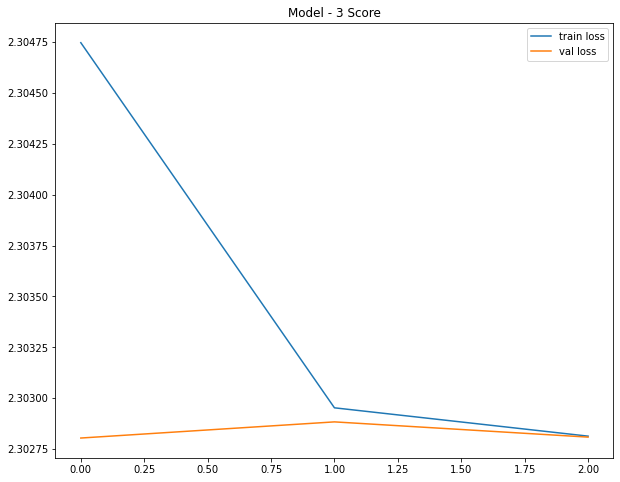

In [ ]:
############# train loss Vs test loss ##########

plt.figure(figsize=(10,8))
plt.plot(history3.history['loss'], label="train loss")
plt.plot(history3.history['val_loss'], label="val loss")
plt.title("Model - 3 Score")
plt.legend()
plt.show()

# Model - 4 

##### We will combine data augmentation and spectrogram and train LSTM Model

In [ ]:
x_train = create_to_spec(aug_train_pad2.astype(np.float32))
x_test = create_to_spec(aug_test_pad2.astype(np.float32))

  0%|          | 0/19330 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((19330, 64, 38), (600, 64, 38), (2400,), (600,))

In [ ]:
## as discussed above, please write the LSTM

#clear the section
tf.keras.backend.clear_session()

input_layer = Input(shape = (64,38), name = 'input_layer')

lstm_layer = LSTM(356, return_sequences = True)(input_layer)

avg_layer = GlobalAveragePooling1D()(lstm_layer)

dense_1 = Dense(units = 128,activation = 'relu')(avg_layer)

dense_2 = Dense(units = 10, activation= 'softmax')(dense_1)

model = Model(inputs = input_layer,outputs = dense_2)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 64, 38)]          0         
                                                                 
 lstm (LSTM)                 (None, 64, 356)           562480    
                                                                 
 global_average_pooling1d (G  (None, 356)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 128)               45696     
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 609,466
Trainable params: 609,466
Non-trainable params: 0
_______________________________________________________

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer= 'adam', metrics = ['accuracy'])

history4 = model.fit(x_train, aug_y_train.astype('int'), 
           epochs = 30,
           batch_size=32, 
           validation_data = (x_test, y_test.astype('int')),
           )

Epoch 1/30
605/605 [==============================] - 6s 7ms/step - loss: 1.8837 - accuracy: 0.3166 - val_loss: 1.6225 - val_accuracy: 0.4167
Epoch 2/30
605/605 [==============================] - 4s 7ms/step - loss: 1.5225 - accuracy: 0.4594 - val_loss: 1.3879 - val_accuracy: 0.5033
Epoch 3/30
605/605 [==============================] - 4s 7ms/step - loss: 1.3667 - accuracy: 0.5098 - val_loss: 1.3037 - val_accuracy: 0.5017
Epoch 4/30
605/605 [==============================] - 4s 7ms/step - loss: 1.2385 - accuracy: 0.5556 - val_loss: 1.1548 - val_accuracy: 0.5933
Epoch 5/30
605/605 [==============================] - 4s 7ms/step - loss: 1.1611 - accuracy: 0.5819 - val_loss: 1.2107 - val_accuracy: 0.5450
Epoch 6/30
605/605 [==============================] - 4s 7ms/step - loss: 1.1035 - accuracy: 0.5992 - val_loss: 1.1750 - val_accuracy: 0.5600
Epoch 7/30
605/605 [==============================] - 4s 7ms/step - loss: 1.0853 - accuracy: 0.6125 - val_loss: 1.1454 - val_accuracy: 0.5683
Epoch 

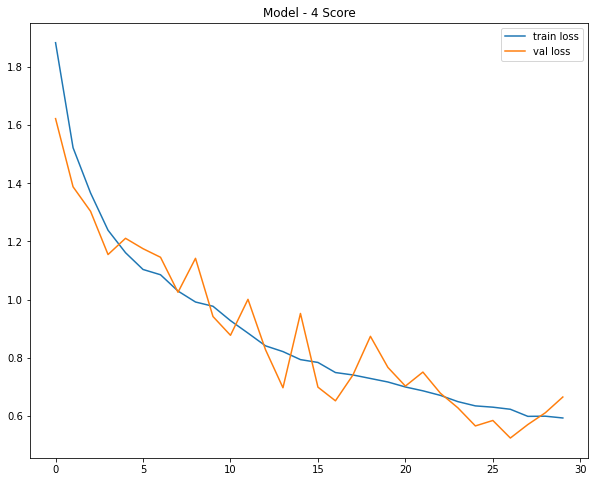

In [ ]:
######## Train and test loss ##########

plt.figure(figsize=(10,8))
plt.plot(history4.history['loss'], label="train loss")
plt.plot(history4.history['val_loss'], label="val loss")
plt.title("Model - 4 Score")
plt.legend()
plt.show()

# Observation

1. we can show that in the model 1 and 3 have poor Accuracy / Micro F1 Score, Raw data pass in Model 1 and and data argumention Pass in Model 3, We can concluded that for the audio dataset argumention and raw data get poor performance.


2. In the model 2 and 4 have high performance in the 50 and 30 epcohs Respectively, We passed sepctrogram converted data into the both model so spectrogram converted data imporove performance of model.


3. Model 4 for get the high Accuracy compare than model - 2 final conclude that after argumentation data we get large amount of data and we convert spectrogram data and get high performance. 
